# Logistic Regression and Analyzing the Bank Data

## Assignment:
This code analyzes the prior marketing campaign data of a Portugeuse bank and the goal is to predict whether the customer will subscribe to fixed-term deposit products the bank is offering. The code cleans the data and imputes the missing values. 

Learn about the data here:  https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

Your assignment:  Study the data and the code.  You can add to the exploratory analysis and imputation if desired.  After exploring the code, complete the logistic regression model for predicting whether the customer will be a subscriber. Suggested evaluation is the ROC curve and AUC metrics. 

You may work with up to two other students - you must be in your group in Canvas (self sign-up) by end of day Friday 9/27 in order to work with other students.  Due:  beginning of class on Wednesday 10/2.

Student names: Sidharth Panda

In [1]:
import numpy as np
import pandas as pd
import random
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import GridSearchCV

Read the dataset, drop the 'duration' variable based on domain knowledge.

In [2]:
df=pd.read_csv("bank-additional-full.csv",sep=';')
df=df.drop(['duration'],axis=1)
print(df.shape)
df.head()

(41188, 20)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


# Exploratory Analysis:

## Categorical Variables:

Explore the categorical variables and see what are the categories and are there any missing values for these categories. 

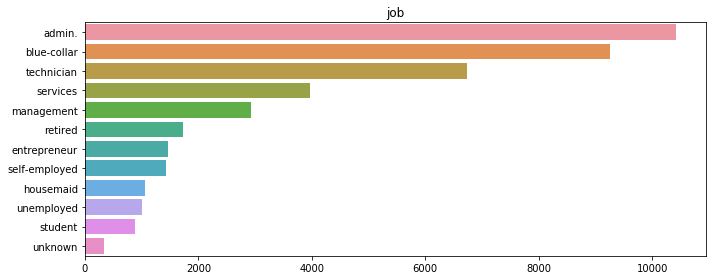

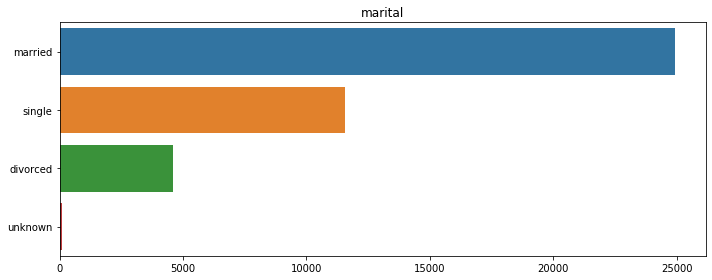

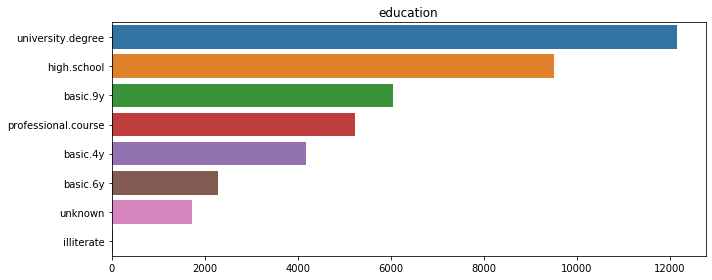

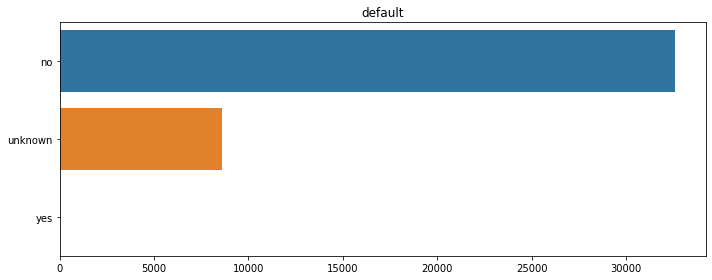

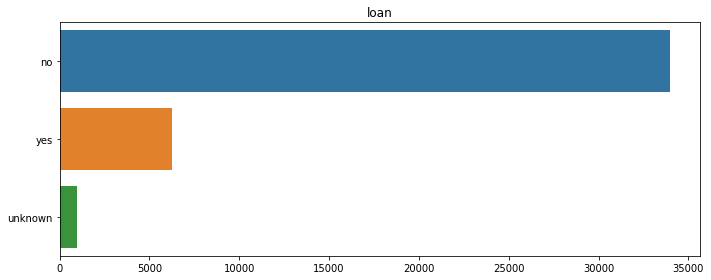

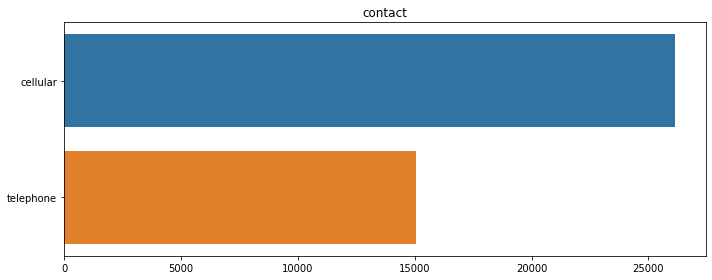

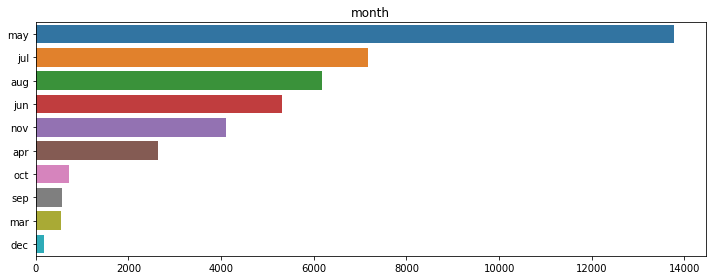

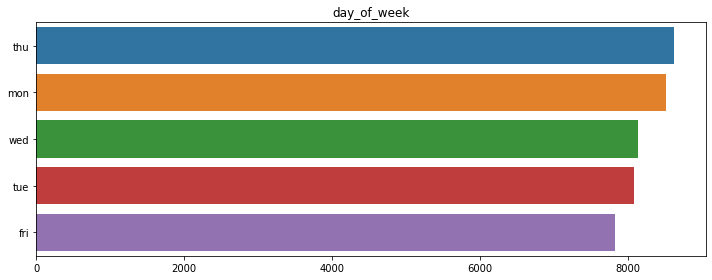

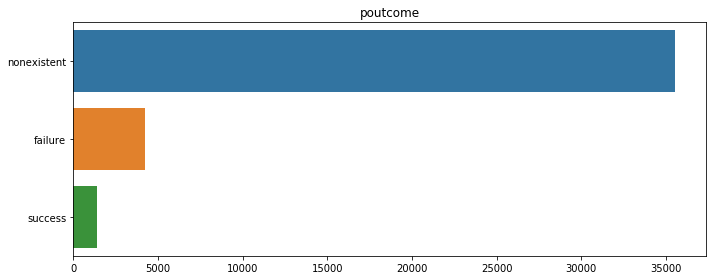

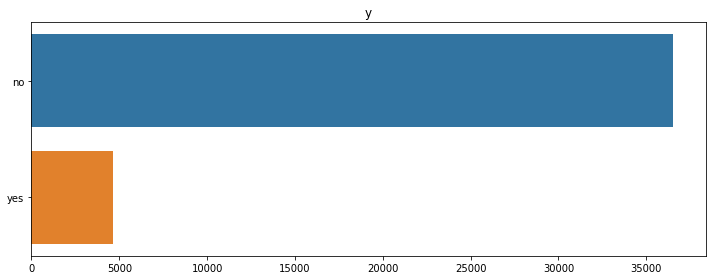

In [3]:
categorcial_variables = ['job', 'marital', 'education', 'default', 'loan', 'contact', 'month', 'day_of_week', 'poutcome','y']
for col in categorcial_variables:
    plt.figure(figsize=(10,4))
    sns.barplot(df[col].value_counts().values, df[col].value_counts().index)
    plt.title(col)
    plt.tight_layout()


## List of normalized relative frequency of the target class per category. 

Normalized distribution of each class per feature and plotted difference between positive and negative frequencies. Positive values imply this category favors clients that will subscribe and negative values categories that favor not buying the product.

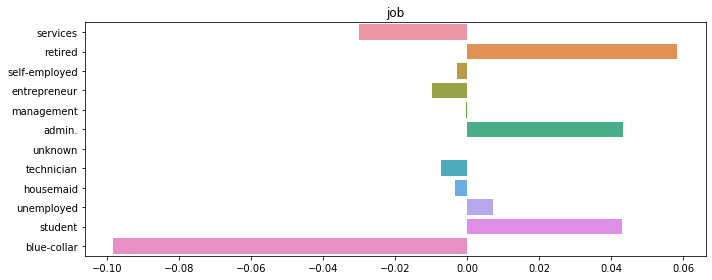

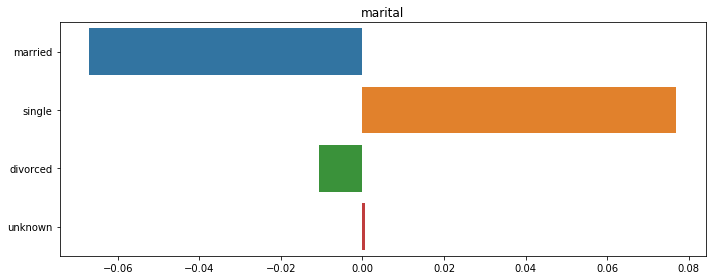

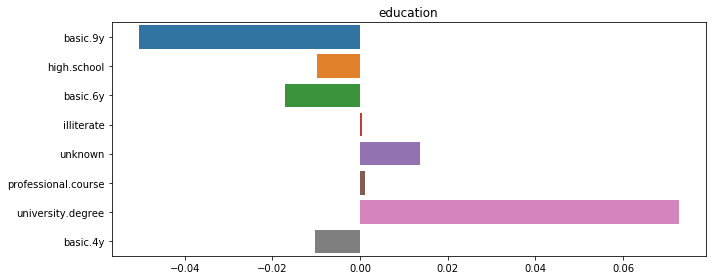

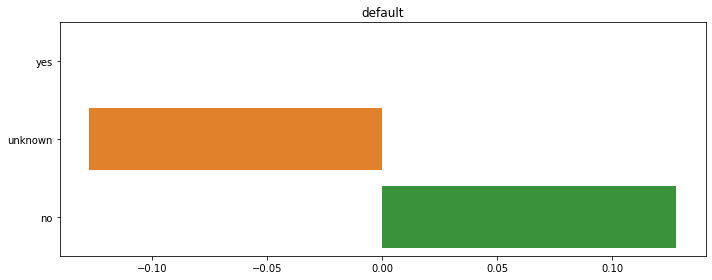

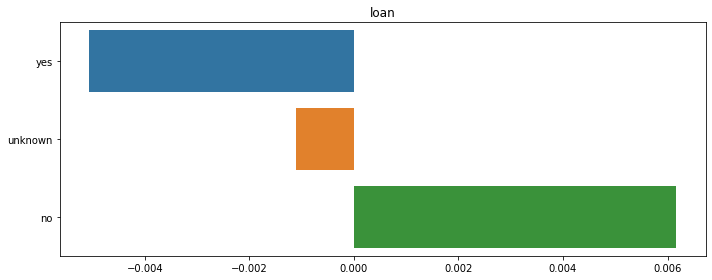

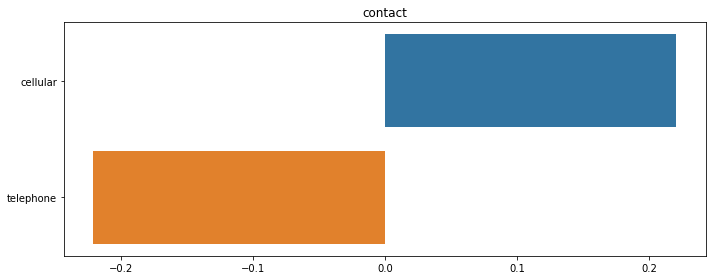

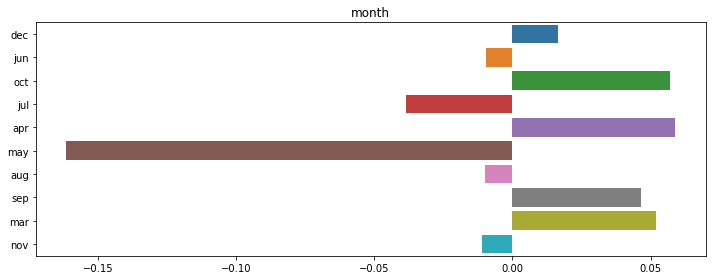

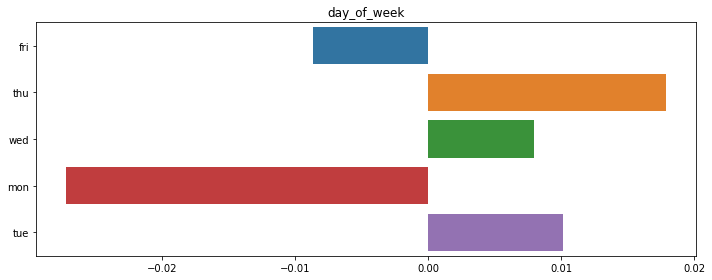

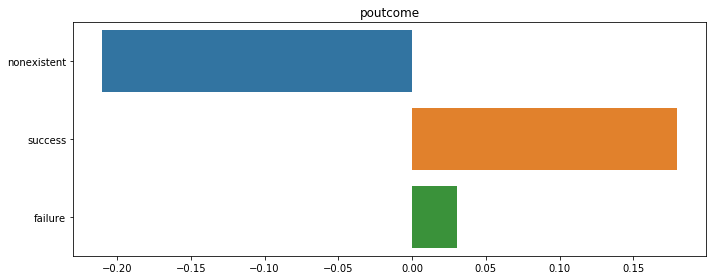

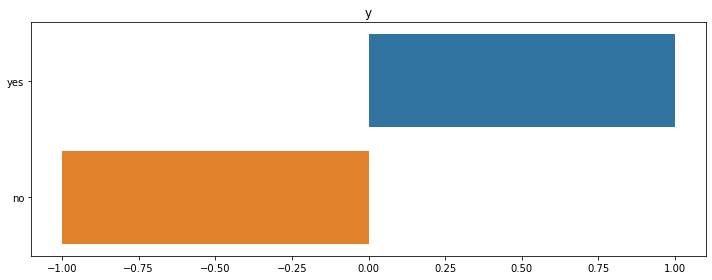

In [4]:
categorcial_variables = ['job', 'marital', 'education', 'default', 'loan', 'contact', 'month', 'day_of_week', 'poutcome','y']
for col in categorcial_variables:
    plt.figure(figsize=(10,4))
    #Returns counts of unique values for each outcome for each feature.
    pos_counts = df.loc[df.y.values == 'yes', col].value_counts() 
    neg_counts = df.loc[df.y.values == 'no', col].value_counts()
    
    all_counts = list(set(list(pos_counts.index) + list(neg_counts.index)))
    
    #Counts of how often each outcome was recorded.
    freq_pos = (df.y.values == 'yes').sum()
    freq_neg = (df.y.values == 'no').sum()
    
    pos_counts = pos_counts.to_dict()
    neg_counts = neg_counts.to_dict()
    
    all_index = list(all_counts)
    all_counts = [pos_counts.get(k, 0) / freq_pos - neg_counts.get(k, 0) / freq_neg for k in all_counts]

    sns.barplot(all_counts, all_index)
    plt.title(col)
    plt.tight_layout()

**Inference/Result**: There are unknown values for many variables in the Data set. There are many ways to handle missing data. One of the ways is to discard the row but that would lead to reduction of data set and hence would not serve our purpose of building an accurate and realistic prediction model.

Other methods include inferring the value of the unknown variable from the other variables. This a way of doing an imputation where we use other independent variables to infer the value of the missing variable. This doesn't gurantee that all missing values will be addressed but majority of them will have a reasonable which can be useful in the prediction. 

Variables with unknown/missing values are : 'education', 'job', 'housing', 'loan', 'deafult', and 'marital'. But the significant ones are 'education', 'job', 'housing', and 'loan'. The number of unknowns  for 'marital' is very low. The unknown for 'default' variable are considered to be recorded as unknown. It may be possible that customer is not willing to disclose this information to the banking representative. Hence the unknown value in 'default' is actually a separate value.


## Imputation:

Now, to infer the missing values in 'job' and 'education', we make use of the cross-tabulation between 'job' and 'education'. Our hypothesis here is that 'job' is influenced by the 'education' of a person. Hence, we can infer 'job' based on the education of the person. Moreover, since we are just filling the missing values, we are not much concerned about the causal inference. We, therefore, can use the job to predict the education.

In [5]:
def cross_tab(df,f1,f2):
    jobs=list(df[f1].unique())
    edu=list(df[f2].unique())
    dataframes=[]
    for e in edu:
        dfe=df[df[f2]==e]
        dfejob=dfe.groupby(f1).count()[f2]
        dataframes.append(dfejob)
    xx=pd.concat(dataframes,axis=1)
    xx.columns=edu
    xx=xx.fillna(0)
    return xx

In [6]:
cross_tab(df,'job','education')

,basic.4y,high.school,basic.6y,basic.9y,professional.course,unknown,university.degree,illiterate
admin.,77,3329,151,499,363,249,5753,1.0
blue-collar,2318,878,1426,3623,453,454,94,8.0
entrepreneur,137,234,71,210,135,57,610,2.0
housemaid,474,174,77,94,59,42,139,1.0
management,100,298,85,166,89,123,2063,0.0
retired,597,276,75,145,241,98,285,3.0
self-employed,93,118,25,220,168,29,765,3.0
services,132,2682,226,388,218,150,173,0.0
student,26,357,13,99,43,167,170,0.0
technician,58,873,87,384,3320,212,1809,0.0


In [7]:
df['job'][df['age']>60].value_counts()

retired          678
housemaid         54
admin.            47
technician        34
management        30
unknown           21
blue-collar       20
self-employed      9
entrepreneur       8
unemployed         7
services           2
Name: job, dtype: int64

** Inferring education from jobs **: From the cross-tabulation, it can be seen that people with management jobs usually have a university degree. Hence wherever 'job' = management and 'education' = unknown, we can replace 'education' with 'university.degree'. Similarly, 'job' = 'services' --> 'education' = 'high.school' and 'job' = 'housemaid' --> 'education' = 'basic.4y'.

** Inferring jobs from education **: If 'education' = 'basic.4y' or 'basic.6y' or 'basic.9y' then the 'job' is usually 'blue-collar'. If 'education' = 'professional.course', then the 'job' = 'technician'.

** Inferring jobs from age**: As we see, if 'age' > 60, then the 'job' is 'retired,' which makes sense.

While imputing the values for job and education, we were cognizant of the fact that the correlations should make real world sense. If it didn't make real world sense, we didn't replace the missing values.

In [8]:
df.loc[(df['age']>60) & (df['job']=='unknown'), 'job'] = 'retired'
df.loc[(df['education']=='unknown') & (df['job']=='management'), 'education'] = 'university.degree'
df.loc[(df['education']=='unknown') & (df['job']=='services'), 'education'] = 'high.school'
df.loc[(df['education']=='unknown') & (df['job']=='housemaid'), 'education'] = 'basic.4y'
df.loc[(df['job'] == 'unknown') & (df['education']=='basic.4y'), 'job'] = 'blue-collar'
df.loc[(df['job'] == 'unknown') & (df['education']=='basic.6y'), 'job'] = 'blue-collar'
df.loc[(df['job'] == 'unknown') & (df['education']=='basic.9y'), 'job'] = 'blue-collar'
df.loc[(df['job']=='unknown') & (df['education']=='professional.course'), 'job'] = 'technician'

In [9]:
cross_tab(df,'job','education')

,basic.4y,high.school,basic.6y,basic.9y,professional.course,unknown,university.degree,illiterate
admin.,77.0,3329,151.0,499.0,363.0,249.0,5753,1.0
blue-collar,2366.0,878,1448.0,3654.0,453.0,454.0,94,8.0
entrepreneur,137.0,234,71.0,210.0,135.0,57.0,610,2.0
housemaid,516.0,174,77.0,94.0,59.0,0.0,139,1.0
management,100.0,298,85.0,166.0,89.0,0.0,2186,0.0
retired,601.0,276,75.0,145.0,243.0,112.0,286,3.0
self-employed,93.0,118,25.0,220.0,168.0,29.0,765,3.0
services,132.0,2832,226.0,388.0,218.0,0.0,173,0.0
student,26.0,357,13.0,99.0,43.0,167.0,170,0.0
technician,58.0,873,87.0,384.0,3330.0,212.0,1809,0.0


The number of unknowns have been reduced.

In [10]:
jobhousing=cross_tab(df,'job','housing')
jobloan=cross_tab(df,'job','loan')

** Imputations for house and loan **: We are again using cross-tabulation between 'house' and 'job' and between 'loan' and 'job.' Our hypothesis is that housing loan status (Yes or No) should be in the proportion of each job category. Hence using the prior known distribution of the housing loan for each job category, the house loan for unknown people will be predicted such that the prior distribution (% House = Yes's and No's for each job category remains the same). Similarly, we have filled the missing values in the 'loan' variable. 

In [11]:
def fillhousing(df,jobhousing):
    """Function for imputation via cross-tabulation to fill missing values for the 'housing' categorical feature"""
    jobs=['housemaid','services','admin.','blue-collar','technician','retired','management','unemployed','self-employed','entrepreneur','student']
    house=["no","yes"]
    for j in jobs:
        ind=df[np.logical_and(np.array(df['housing']=='unknown'),np.array(df['job']==j))].index
        mask=np.random.rand(len(ind))<((jobhousing.loc[j]['no'])/(jobhousing.loc[j]['no']+jobhousing.loc[j]['yes']))
        ind1=ind[mask]
        ind2=ind[~mask]
        df.loc[ind1,"housing"]='no'
        df.loc[ind2,"housing"]='yes'
    return df

In [12]:
def fillloan(df,jobloan):
    """Function for imputation via cross-tabulation to fill missing values for the 'loan' categorical feature"""
    jobs=['housemaid','services','admin.','blue-collar','technician','retired','management','unemployed','self-employed','entrepreneur','student']
    loan=["no","yes"]
    for j in jobs:
        ind=df[np.logical_and(np.array(df['loan']=='unknown'),np.array(df['job']==j))].index
        mask=np.random.rand(len(ind))<((jobloan.loc[j]['no'])/(jobloan.loc[j]['no']+jobloan.loc[j]['yes']))
        ind1=ind[mask]
        ind2=ind[~mask]
        df.loc[ind1,"loan"]='no'
        df.loc[ind2,"loan"]='yes'
    return df

In [13]:
df=fillhousing(df,jobhousing)

In [14]:
df=fillloan(df,jobloan)

##  Numerical variables:

Summary of the data in order to understand the numerical variables.

In [15]:
numerical_variables = ['age','campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx','cons.conf.idx','euribor3m',
                      'nr.employed']
df[numerical_variables].describe()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


**Missing Values: **From the source of the data (U.C. Irvine ML Repository), missing values, or NaNs, are encoded as '999'. From the above table, it is clear that only 'pdays' has missing values. Moreover, a majority of the values for 'pdays' are missing.

**Outliers:** Outliers are defined as 1.5 x Q3 value (75th percentile). From the above table, it can be seen that only 'age' and 'campaign' have outliers as max('age') and max('campaign') > 1.5*Q3('age') and >1.5*Q3('campaign') respectively.

You can also see that the value of these outliers are not so unrealistic (max('age')=98 and max('campaign')=56). Hence, we need not remove them since the prediction model should represent the real world. This improves the generalizability of the model and makes it robust for real world situations. The outliers, therefore, are not removed.


## Missing Values in Numerical Variables
Let's examine the missing values in 'pdays'

In [16]:
def drawhist(df,feature):
    plt.hist(df[feature])

Filtered out missing values encoded with an out-of-range value when plotting the histogram of values in order to properly understand the distribution of the known values. Here, histograms were created using matplotlib.

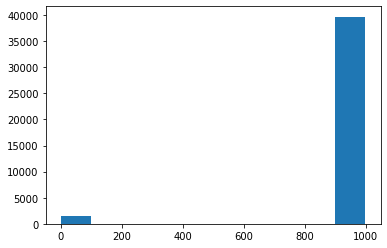

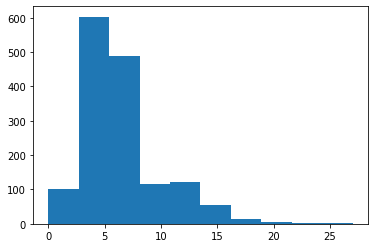

In [17]:
drawhist(df,'pdays')
plt.show()

plt.hist(df.loc[df.pdays != 999, 'pdays'])
plt.show()

In [18]:
pd.crosstab(df['pdays'],df['poutcome'], values=df['age'], aggfunc='count', normalize=True)

poutcome,failure,nonexistent,success
pdays,,,
0,0.000000,0.000000,0.000364
1,0.000000,0.000000,0.000631
2,0.000000,0.000000,0.001481
3,0.000097,0.000000,0.010561
4,0.000049,0.000000,0.002816
5,0.000097,0.000000,0.001020
6,0.000607,0.000000,0.009396
7,0.000364,0.000000,0.001093
8,0.000146,0.000000,0.000291


As we can see from the above table, the majority of the values for 'pdays' are missing. The majority of these missing values occur when the 'poutcome' is 'non-existent'. This means that the majority of the values in 'pdays' are missing because the customer was never contacted before. To deal with this variable, we removed the numerical variable 'pdays' and replaced it with categorical variables with following categories: p_days_missing, pdays_less_5, pdays_bet_5_15, and pdays_greater_15.

In [19]:
#Add new categorical variables to our dataframe.
df['pdays_missing'] = 0
df['pdays_less_5'] = 0
df['pdays_greater_15'] = 0
df['pdays_bet_5_15'] = 0
df['pdays_missing'][df['pdays']==999] = 1
df['pdays_less_5'][df['pdays']<5] = 1
df['pdays_greater_15'][(df['pdays']>15) & (df['pdays']<999)] = 1
df['pdays_bet_5_15'][(df['pdays']>=5)&(df['pdays']<=15)]= 1
df_dropped_pdays = df.drop('pdays', axis=1);

For categorical variables, dummy variables need to be created.

In [20]:
df_with_dummies=pd.get_dummies(df_dropped_pdays)

Drop one of the dummy variables as for $n$ categories we only need $n$-1 dummy variables.

In [21]:
def dropfeature(df,f):
    """Drops one of the dummy variables."""
    df=df.drop(f,axis=1)
    return df

In [22]:
features_dropped = ['default_no','housing_no','loan_no','y_no','marital_single','contact_cellular',
                    'education_unknown','job_unknown','housing_unknown','loan_unknown', 'pdays_less_5']
df_clean = dropfeature(df_with_dummies, features_dropped)

## Some helper functions to build and evaluate the models

In [23]:
def drawheatmap(df):
    '''Builds the heat map for the given data'''
    f, ax = plt.subplots(figsize=(15, 15))
    sns.heatmap(df.corr(method='spearman'), annot=False, cmap='coolwarm')
    
def drawhist(df,feature):
    '''Draws an histogram for a feature in a data frame (df)'''
    plt.hist(df[feature])

def functionreplace(df,fea,val1,val2):
    '''Replaces value (val1) with value (val2) in the data frame (df) for a feature (fea)'''
    df[fea].replace(val1,val2)
    return df

def drawbarplot(df,x,y):
    '''Draws a bar plot for a given feature x and y in a data frame'''
    sns.barplot(x=x, y=y, data=df)
    

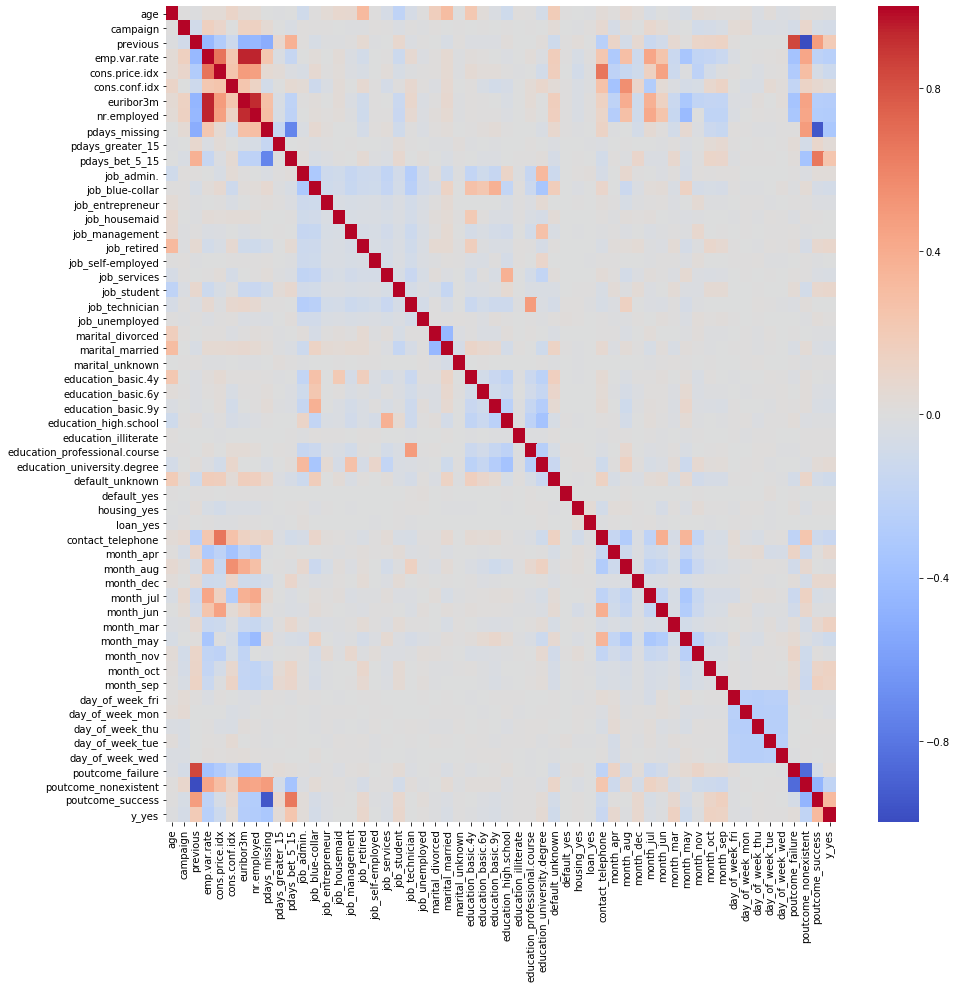

In [24]:
drawheatmap(df_clean)

**Inferences**: From the above heat map we can see that 'y_yes' (our target variable) has good correlation with **'previous', 'emp.var.rate', 'euribor3m', 'nr.employed', 'pdays_missing', 'poutcome_success' , 'poutcome_nonexistent'and 'pdays_bet_5_15'**. We expect to see these independent variables as significant while building the models.

# Model Building and Evaluation

**Train Test Split **: Start with splitting the data into training and testing. A five-fold cross validation will be used.

Additionally, stratification (keeping the target distribution unchanged) is used since dataset is highly imbalanced. A random train/test split will probably change the target distribution quite a bit.

In [25]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_clean, train_size=0.8, random_state=5)
print('Original:', (df_clean.y_yes).mean(), 'Train:', (train.y_yes).mean(), 'Test:', (test.y_yes).mean())

train, test = train_test_split(df_clean, train_size=0.8, stratify=df_clean.y_yes.values, random_state=5)
print('Original:', (df_clean.y_yes).mean(), 'Train:', (train.y_yes).mean(), 'Test:', (test.y_yes).mean())

Original: 0.11265417111780131 Train: 0.11068285280728377 Test: 0.12053896576839039
Original: 0.11265417111780131 Train: 0.11265553869499241 Test: 0.11264870114105366


In [26]:
df_clean.head()

,age,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pdays_missing,pdays_greater_15,...,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y_yes
0,56,1,0,1.1,93.994,-36.4,4.857,5191.0,1,0,...,0,0,1,0,0,0,0,1,0,0
1,57,1,0,1.1,93.994,-36.4,4.857,5191.0,1,0,...,0,0,1,0,0,0,0,1,0,0
2,37,1,0,1.1,93.994,-36.4,4.857,5191.0,1,0,...,0,0,1,0,0,0,0,1,0,0
3,40,1,0,1.1,93.994,-36.4,4.857,5191.0,1,0,...,0,0,1,0,0,0,0,1,0,0
4,56,1,0,1.1,93.994,-36.4,4.857,5191.0,1,0,...,0,0,1,0,0,0,0,1,0,0


## Logistic Regression Model:  Your assignment
Build a Logistic Regression model and evaluate.  The suggested evaluation is using the ROC curve and the AUC values. The positive and the negative class are heavily imbalanced, therefore the ROC curve and the AUC values are appropriate evaluation metrics as compared to the accuracy. 


<h3>Now we have to split the data into training and testing datasets using train_test_split from sklearn.model_selection<p>After spliting, we check the shape of the respective datasets if they contain equal number of data or not.<p> So we use .shape() to check the data.</h3>

In [51]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score

df_clean.head()
X = df_clean[['previous', 'emp.var.rate', 'euribor3m', 'nr.employed', 'pdays_missing', 'poutcome_success' , 'poutcome_nonexistent','pdays_bet_5_15']]
y = df_clean['y_yes']
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(32950, 8)
(8238, 8)
(32950,)
(8238,)


<h3>After verifying all the datasets, we import the logistic regression from sklearn and fit the training sets in to the model<p> We also checked the accuracy and cross_val_score of X and Y with respect to eachother to verify the difference between training and test datasets.</h3>

accuracy:  [0.8873513  0.88929352 0.88783685 0.88733762 0.69297074]
cross_val_score:  0.8489580070008425


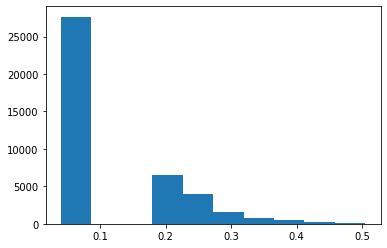

  |     0     1 |
--+-------------+
0 |<36548>    . |
1 |  4639    <1>|
--+-------------+
(row = reference; col = test)



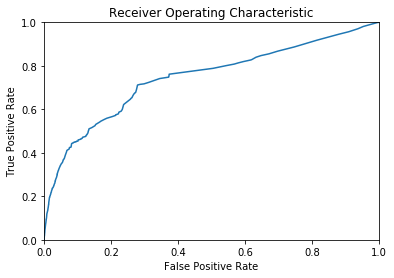

AUC : 0.7440820945671822


0.6854460966131355

In [50]:
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression()
logreg.fit(X_train,Y_train)

predicted = cross_val_predict(logreg, X, y, cv=10)
metrics.accuracy_score(y, predicted) 

accuracy = cross_val_score(logreg, X, y, cv=5,scoring='accuracy')
print ("accuracy: ",accuracy)
print ("cross_val_score: ",cross_val_score(logreg, X, y, cv=5,scoring='accuracy').mean())
probs = logreg.predict_proba(X)[:, 1] 
plt.hist(probs) 
plt.show()

# use 0.5 cutoff for predicting 'default' 
import numpy as np 
preds = np.where(probs > 0.5, 1, 0) 
print (ConfusionMatrix(list(y), list(preds)))

plt.title('Receiver Operating Characteristic')
fpr, tpr, thresholds = metrics.roc_curve(y, probs) 
plt.plot(fpr, tpr) 
plt.xlim([0, 1]) 
plt.ylim([0, 1]) 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.show()

# calculate AUC 
print ("AUC :",metrics.roc_auc_score(y, probs))

# use AUC as evaluation metric for cross-validation   
cross_val_score(logreg, X, y, cv=5, scoring='roc_auc').mean()